## Prepare dataset

Under following cells, we will read data under `data` folder and convert them into pandas dataframe. `senario` property will be used as df name while `examples` will be converted into rows.

fetch them from `dfs['<property>']`

In [1]:
import sys

sys.path.append("../../")  # import src

In [2]:
import json
from pathlib import Path

import pandas as pd

data_dir = Path("/Users/drakezhou/Development/big-poc/src/data")

dfs = {}
for json_path in data_dir.glob("*.json"):
    with json_path.open(encoding="utf-8") as f:
        obj = json.load(f)
    senario_name = obj["senario"]

    cdf = pd.DataFrame(obj["examples"])

    match senario_name:
        case "valid_can_do":
            cdf["target_within_domain"] = True
            cdf["target_within_capacity"] = True
        case "valid_cannot_do":
            cdf["target_within_domain"] = True
            cdf["target_within_capacity"] = False
        case "invalid":
            cdf["target_within_domain"] = False
            cdf["target_within_capacity"] = False
        case _:
            raise ValueError(f"Unknown senario: {senario_name}")

    dfs[senario_name] = cdf

# Example
dfs["valid_can_do"].head()

,conversation_id,dialogue,description,target_within_domain,target_within_capacity
0,1,"[{'role': 'user', 'message': '帮我做一下纯化'}]",给机器人的指令，做整个流程,True,True
1,2,"[{'role': 'user', 'message': 'Hi Labbot'}, {'r...",给机器人的指令，做过柱这一步,True,True
2,3,"[{'role': 'user', 'message': 'Hi Robot'}, {'ro...",设计过柱任务的条件,True,True
3,4,"[{'role': 'user', 'message': '我昨天安排你做的任务现在怎么样啦'}]",查询任务进展,True,True


## Benchmark

Use to evaluate the performance of each node

In [3]:
from typing import TYPE_CHECKING

from langchain_core.messages import AIMessage, AnyMessage, HumanMessage
from src.functions.admittance import WatchDogAgent

if TYPE_CHECKING:
    from src.classes.operation import OperationResponse
    from src.classes.system_state import UserAdmittance

watch_dog = WatchDogAgent()


def run_watch_dog_agent(dataset: pd.DataFrame) -> pd.DataFrame:
    within_domain_list: list[bool] = []
    within_capacity_list: list[bool] = []
    feedback_list: list[str] = []

    for _, row in dataset.iterrows():
        input_msg = []
        for msg in row["dialogue"]:
            if msg["role"] == "assistant":
                input_msg.append(AIMessage(content=msg["message"]))
            elif msg["role"] == "user":
                input_msg.append(HumanMessage(content=msg["message"]))

        res: OperationResponse[list[AnyMessage], UserAdmittance] = watch_dog.run(
            user_input=input_msg,
            stream_mode=False,
        )
        within_domain_list.append(res.output.within_domain)
        within_capacity_list.append(res.output.within_capacity)
        feedback_list.append(res.output.feedback)

    dataset = dataset.copy()
    dataset["within_domain"] = within_domain_list
    dataset["within_capacity"] = within_capacity_list
    dataset["feedback"] = feedback_list
    return dataset

Valid Can Do

In [4]:
# Evaluate performance using `Valid Can DO` Dataset

eval_df = run_watch_dog_agent(dfs["valid_can_do"])

2025-12-11 14:56:41.751 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:56:51.146 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=True, within_capacity=True
2025-12-11 14:56:51.150 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:56:59.824 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=True, within_capacity=True
2025-12-11 14:56:59.825 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:57:05.821 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=True, within_capacity=True
2025-12-11 14:57:05.822 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:57:09.249 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=True, within_capaci

In [5]:
# Add configuration information and show
version_control = {
    "model": "gpt-5.1",
    "prompt_version": "v1",
}

eval_df["version_control"] = [version_control] * len(dfs["valid_can_do"])

eval_df.head()

,conversation_id,dialogue,description,target_within_domain,target_within_capacity,within_domain,within_capacity,feedback,version_control
0,1,"[{'role': 'user', 'message': '帮我做一下纯化'}]",给机器人的指令，做整个流程,True,True,True,True,可以的，我可以帮你安排纯化相关的机器人任务。\n\n为了继续，请补充一些关键信息：\n1. ...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
1,2,"[{'role': 'user', 'message': 'Hi Labbot'}, {'r...",给机器人的指令，做过柱这一步,True,True,True,True,没问题，我可以帮你设计和安排过柱条件。\n\n为了更准确地给你建议，请先补充这些关键信息：\...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
2,3,"[{'role': 'user', 'message': 'Hi Robot'}, {'ro...",设计过柱任务的条件,True,True,True,True,可以的，我可以帮你设计过柱条件。请先提供一些关键信息：\n1）化合物的结构或至少官能团信息（...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
3,4,"[{'role': 'user', 'message': '我昨天安排你做的任务现在怎么样啦'}]",查询任务进展,True,True,True,True,你可以告诉我具体是哪个任务吗？例如：过柱纯化哪个化合物、哪批LC-MS送样、哪个DMPK稳定...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"


valid_cannot_do

In [6]:
eval_valid_cannot_do = run_watch_dog_agent(dfs["valid_cannot_do"])

version_control = {
    "model": "gpt-5.1",
    "prompt_version": "v1",
}

eval_valid_cannot_do["version_control"] = [version_control] * len(dfs["valid_cannot_do"])

eval_valid_cannot_do.head()

2025-12-11 14:57:09.360 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:57:17.429 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=True, within_capacity=True
2025-12-11 14:57:17.436 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:57:22.563 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=False, within_capacity=True
2025-12-11 14:57:22.564 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:57:30.221 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=False, within_capacity=True
2025-12-11 14:57:30.222 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:57:43.562 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=False, within_cap

,conversation_id,dialogue,description,target_within_domain,target_within_capacity,within_domain,within_capacity,feedback,version_control
0,1,"[{'role': 'user', 'message': '帮我做下萃取'}]",小分子的场景，但是还未实现,True,False,True,True,我可以帮你设计和安排萃取，但需要更多信息：\n\n1）这是哪一步实验？比如：反应后工作up、...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
1,2,"[{'role': 'user', 'message': 'Hi Labbot'}, {'r...",小分子的场景，但是还未实现,True,False,False,True,目前我只能协助小分子有机合成和 DMPK 实验室相关的内容，比如：\n- 机器人实验任务（T...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
2,3,"[{'role': 'user', 'message': 'Hi Robot'}, {'ro...",非任务级别，缺乏上下文,True,False,False,True,当前系统是面向小分子合成和 DMPK 实验室场景的对话助手，主要支持：机器人任务布置（如TL...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
3,4,"[{'role': 'user', 'message': '我昨天用过的烧杯在哪里'}]",非任务级别的问询，缺乏上下文,True,False,False,True,当前系统只支持小分子合成与 DMPK 实验场景下：机器人任务布置（如TLC、过柱、LC-MS...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"


Invalid

In [7]:
eval_invalid = run_watch_dog_agent(dfs["invalid"])

version_control = {
    "model": "gpt-5.1",
    "prompt_version": "v1",
}

eval_invalid["version_control"] = [version_control] * len(dfs["invalid"])

eval_invalid.head()

2025-12-11 14:57:43.634 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:57:48.557 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=False, within_capacity=True
2025-12-11 14:57:48.558 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:57:54.732 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=False, within_capacity=True
2025-12-11 14:57:54.733 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:58:00.563 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=False, within_capacity=True
2025-12-11 14:58:00.563 | INFO     | src.functions.admittance:run:45 - WatchDogAgent.run triggered. stream_mode=False
2025-12-11 14:58:07.128 | INFO     | src.functions.admittance:run:48 - WatchDogAgent result: within_domain=False, within_ca

,conversation_id,dialogue,description,target_within_domain,target_within_capacity,within_domain,within_capacity,feedback,version_control
0,1,"[{'role': 'user', 'message': '帮我揍宇轩一顿'}]",和实验室任务无关,False,False,False,True,当前系统只面向小分子合成与 DMPK 实验室相关内容，例如：布置机器人实验任务、咨询 TLC...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
1,2,"[{'role': 'user', 'message': 'Hi Labbot'}, {'r...",与实验室任务无关,False,False,False,True,当前系统 Talos 只支持与小分子合成、纯化、DMPK 稳定性测试相关的实验问题，以及实验...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
2,3,"[{'role': 'user', 'message': 'Hi Robot'}, {'ro...",属于实验室任务，但是与小分子合成，DMPK无关,False,False,False,True,目前我所在的系统是面向“小分子合成与 DMPK 实验室”的助手（支持如TLC/过柱/LC-M...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
3,4,"[{'role': 'user', 'message': '细胞培养得怎么样啦'}]",属于实验室任务，但是与小分子合成，DMPK无关,False,False,False,True,当前系统 Talos 只面向小分子合成及 DMPK 实验室场景，支持的是：\n- 机器人相关...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"


,precision,recall,f1-score,support
False,0.571429,1.0000,0.727273,4.00
True,1.000000,0.6250,0.769231,8.00
accuracy,0.750000,0.7500,0.750000,0.75
macro avg,0.785714,0.8125,0.748252,12.00
weighted avg,0.857143,0.7500,0.755245,12.00


,precision,recall,f1-score,support
False,0.000000,0.000000,0.000000,8.000000
True,0.333333,1.000000,0.500000,4.000000
accuracy,0.333333,0.333333,0.333333,0.333333
macro avg,0.166667,0.500000,0.250000,12.000000
weighted avg,0.111111,0.333333,0.166667,12.000000


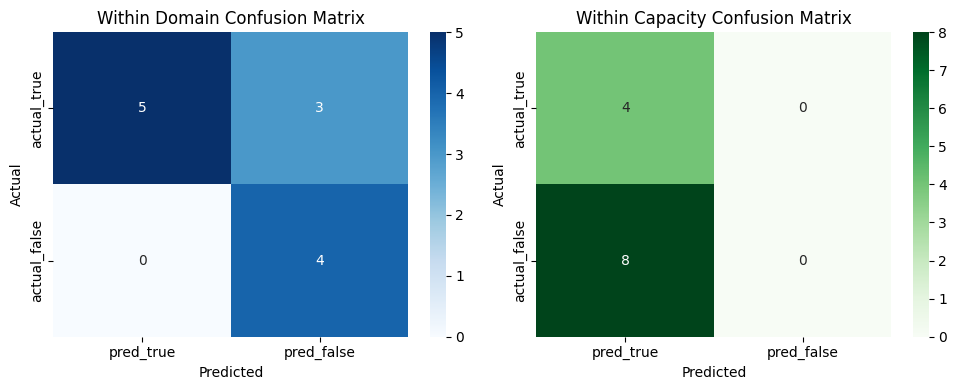

In [8]:
import matplotlib.pyplot as plt  # pyright: ignore[reportMissingImports]
import seaborn as sns  # pyright: ignore[reportMissingImports]
from sklearn.metrics import classification_report, confusion_matrix  # pyright: ignore[reportMissingImports]

# Aggregate evaluation across all datasets and plot confusion matrices
combined_eval = pd.concat(
    [
        eval_df.assign(senario="valid_can_do"),
        eval_valid_cannot_do.assign(senario="valid_cannot_do"),
        eval_invalid.assign(senario="invalid"),
    ],
    ignore_index=True,
)


def compute_binary_metrics(df: pd.DataFrame, target_col: str, pred_col: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    y_true = df[target_col]
    y_pred = df[pred_col]
    report = classification_report(
        y_true,
        y_pred,
        output_dict=True,
        zero_division=0,
    )
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    cm_df = pd.DataFrame(
        cm,
        index=pd.Index(["actual_true", "actual_false"]),
        columns=pd.Index(["pred_true", "pred_false"]),
    )
    return pd.DataFrame(report).T, cm_df


domain_report, domain_cm = compute_binary_metrics(
    combined_eval,
    target_col="target_within_domain",
    pred_col="within_domain",
)
capacity_report, capacity_cm = compute_binary_metrics(
    combined_eval,
    target_col="target_within_capacity",
    pred_col="within_capacity",
)

display(domain_report)
display(capacity_report)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(
    domain_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[0],
)
axes[0].set_title("Within Domain Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(
    capacity_cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    ax=axes[1],
)
axes[1].set_title("Within Capacity Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()